In [1]:
import pandas as pd

In [2]:

from pathlib import Path
import tensorflow as tf

In [36]:
import os

train_folder = '/content/Food-Recognition-and-Calorie-Estimation/train'

# Listing all files in the train folder
train_images = os.listdir(train_folder)
print(train_images)


['Pizza', 'Pav Bhaji', 'Butter Naan', 'Chapathi', 'Samosa', 'Idli', 'Ice Cream', 'Chicken Curry', 'Dosa', 'Biryani']


In [5]:
train_dir = '/content/Food-Recognition-and-Calorie-Estimation/train'
test_dir = '/content/Food-Recognition-and-Calorie-Estimation/test'

In [6]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)


In [7]:
test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [8]:
train_images = train_generator.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

Found 1609 images belonging to 10 classes.


In [9]:
val_images = train_generator.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)


Found 400 images belonging to 10 classes.


In [10]:
test_images = test_generator.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)


Found 500 images belonging to 10 classes.


In [11]:
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [12]:
pretrained_model.trainable = False

In [13]:
inputs = pretrained_model.input
x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(10, activation='softmax')(x)

In [14]:
model = tf.keras.Model(inputs, outputs)


In [15]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [16]:
history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=20,
    callbacks=[tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True
    )]
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4392 - loss: 1.6805

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


51/51 ━━━━━━━━━━━━━━━━━━━━ 115s 2s/step - accuracy: 0.4424 - loss: 1.6708 - val_accuracy: 0.8550 - val_loss: 0.4586
Epoch 2/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 103s 2s/step - accuracy: 0.8581 - loss: 0.4139 - val_accuracy: 0.8825 - val_loss: 0.3833
Epoch 3/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 122s 2s/step - accuracy: 0.9465 - loss: 0.2263 - val_accuracy: 0.9100 - val_loss: 0.2580
Epoch 4/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 111s 2s/step - accuracy: 0.9680 - loss: 0.1324 - val_accuracy: 0.8950 - val_loss: 0.2688
Epoch 5/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 120s 2s/step - accuracy: 0.9877 - loss: 0.0639 - val_accuracy: 0.8925 - val_loss: 0.2971
Epoch 6/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 101s 2s/step - accuracy: 0.9982 - loss: 0.0335 - val_accuracy: 0.9125 - val_loss: 0.2320
Epoch 7/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - accuracy: 1.0000 - loss: 0.0202 - val_accuracy: 0.9075 - val_loss: 0.2338
Epoch 8/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 119s 2s/step - accuracy: 1.0000 - loss: 0.0123 - val_accuracy: 0.9075 - val_loss: 0.2

In [18]:
model.save('nutrition_detection.keras')

In [19]:
results = model.evaluate(test_images, verbose=0)
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

Test Accuracy: 88.20%


In [22]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


In [23]:
predictions = np.argmax(model.predict(test_images), axis=1)

cm = confusion_matrix(test_images.labels, predictions)
clr = classification_report(test_images.labels, predictions, target_names=test_images.class_indices, zero_division=0)




16/16 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step


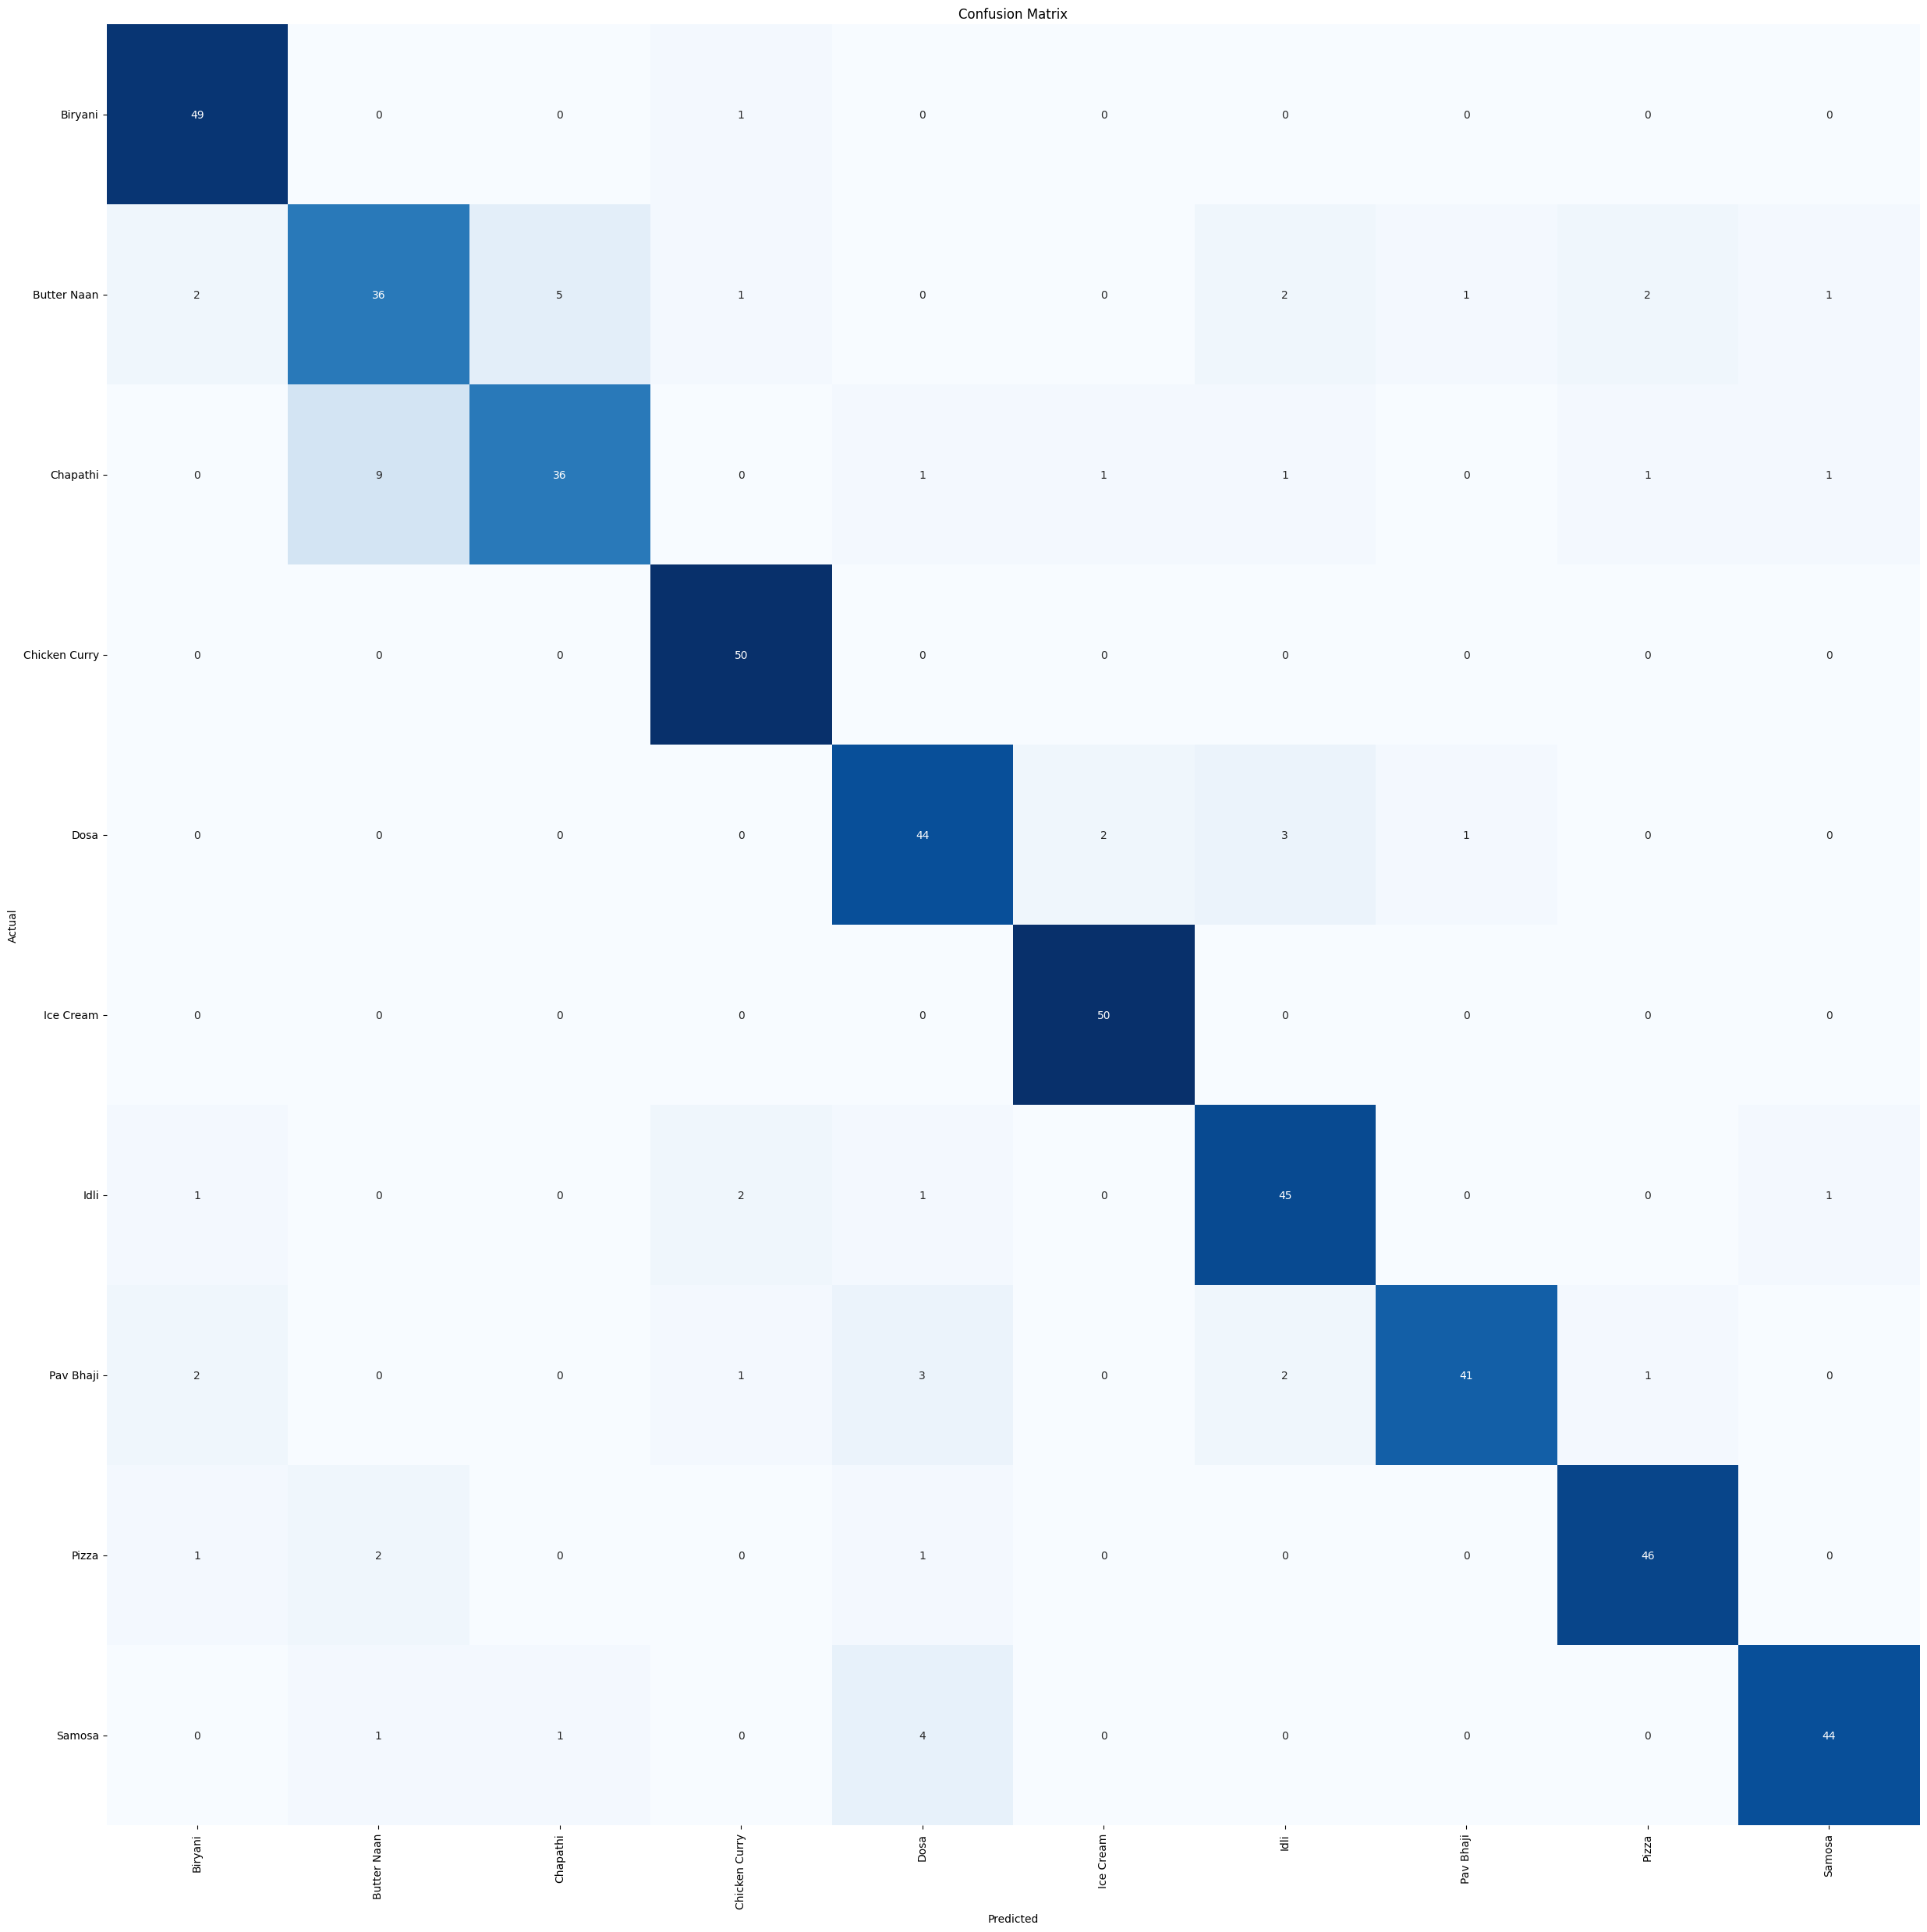

In [25]:
plt.figure(figsize=(30, 30))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks=np.arange(10) + 0.5, labels=test_images.class_indices, rotation=90)
plt.yticks(ticks=np.arange(10) + 0.5, labels=test_images.class_indices, rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [26]:
print("Classification Report:\n----------------------\n", clr)

Classification Report:
----------------------
                precision    recall  f1-score   support

      Biryani       0.89      0.98      0.93        50
  Butter Naan       0.75      0.72      0.73        50
     Chapathi       0.86      0.72      0.78        50
Chicken Curry       0.91      1.00      0.95        50
         Dosa       0.81      0.88      0.85        50
    Ice Cream       0.94      1.00      0.97        50
         Idli       0.85      0.90      0.87        50
    Pav Bhaji       0.95      0.82      0.88        50
        Pizza       0.92      0.92      0.92        50
       Samosa       0.94      0.88      0.91        50

     accuracy                           0.88       500
    macro avg       0.88      0.88      0.88       500
 weighted avg       0.88      0.88      0.88       500



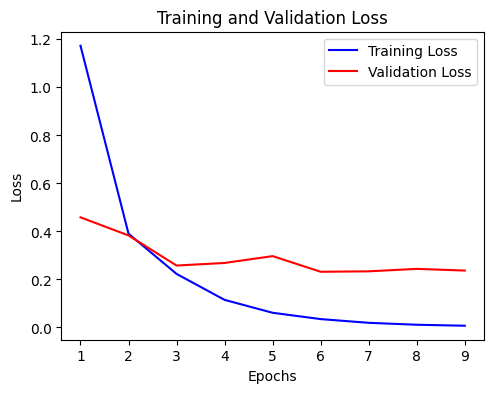

In [27]:
import matplotlib.pyplot as plt

# Extract the history data
history_dict = history.history

# Get training and validation accuracy and loss
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']
train_acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

# Define number of epochs
epochs = range(1, len(train_loss) + 1)

# Plot Training and Validation Loss
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

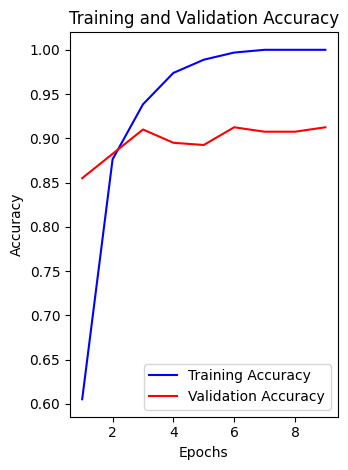

In [28]:
# Plot Training and Validation Accuracy
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
plt.plot(epochs, train_acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Display the plots
plt.tight_layout()
plt.show()


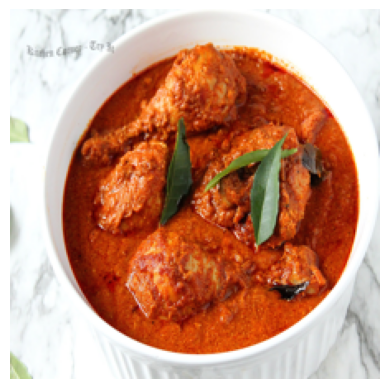

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
Predicted label: Chicken Curry
There are  290 kcal in  1 bowl (150 grams) of Chicken Curry.


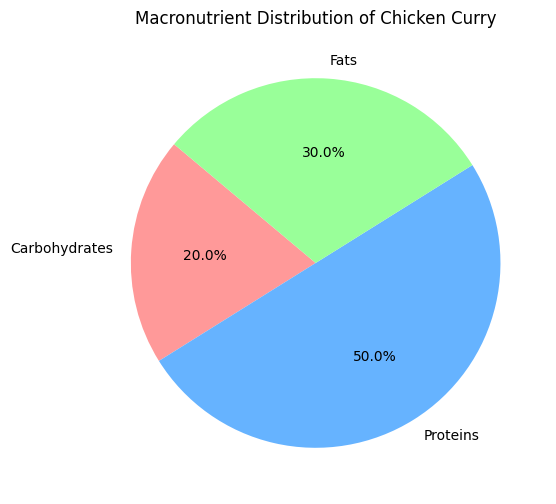

In [35]:
import pandas as pd
from tensorflow.keras.preprocessing import image
import numpy as np
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from PIL import Image
import matplotlib.pyplot as plt

# Load the calorie dataset
calorie_df = pd.read_csv('/content/calorie_dataset.csv')

def predict_and_display_calories(img_path, model, calorie_df):
    # Load and display the image
    img = Image.open(img_path)
    img = img.resize((224, 224))

    plt.imshow(img)
    plt.axis('off')  # Hide axes
    plt.show()

    # Preprocess the image
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    # Predict the class
    predictions = model.predict(img_array)
    predicted_class_index = np.argmax(predictions[0])

    # Reverse the class indices to get class labels
    class_indices = train_images.class_indices
    label_map = {v: k for k, v in class_indices.items()}
    predicted_label = label_map[predicted_class_index]

    # Fetch calorie information
    calorie_info = calorie_df[calorie_df['Label'] == predicted_label]

    if not calorie_info.empty:
        # Extract the information
        calorie_info_row = calorie_info.iloc[0]
        caloric_value = calorie_info_row['Caloric Value']
        carbohydrates = calorie_info_row['Carbohydrates']
        proteins = calorie_info_row['Proteins']
        fats = calorie_info_row['Fats']
        weight = calorie_info_row['Weight']

        print(f'Predicted label: {predicted_label}')
        print(f'There are {caloric_value} in {weight} of {predicted_label}.')

        # Pie chart for macronutrients
        labels = ['Carbohydrates', 'Proteins', 'Fats']
        sizes = [float(carbohydrates.split()[0]), float(proteins.split()[0]), float(fats.split()[0])]
        colors = ['#ff9999','#66b3ff','#99ff99']

        plt.figure(figsize=(8, 6))
        plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
        plt.title(f'Macronutrient Distribution of {predicted_label}')
        plt.show()

    else:
        print(f'No calorie information found for label: {predicted_label}')

# Example usage
img_path = '/content/Malabar chicken curry 16.JPG'  # Replace with your image path
predict_and_display_calories(img_path, model, calorie_df)